In [11]:
import numpy as np

def arm_dist(q):
    return q + np.random.normal(0, 0.01)

In [12]:
arms = {}
n_arms = 10

for i in range(n_arms):
    arms[i] = arm_dist

In [13]:
init_q = .25
eps = [.1, .01, 0]
results = {}

# init q values
arm_values = np.zeros(n_arms)
n_pulled = np.zeros(n_arms)
for i in range(n_arms):
    arm_values[i] = arms[i](init_q)

steps = np.arange(1, 1001, 1)

for ep in eps:
    average_rewards = []
    for step in steps:
        rewards = []
        for _ in range(step):
            # select arm
            # non-greedy case
            if np.random.uniform(0,1) < ep:
                arm = np.random.randint(0, len(arms))
            # greedy case
            else:
                arm = np.argmax(arm_values)
            
            # update arm value
            n_pulled[arm] += 1
            q = arm_values[arm]

            # stationary
            r = np.random.normal(q, 1) # from a normal distribution with mean q_star(A_t) and variance 1, page 29
            rewards.append(r)
            q = q + (r - q)/n_pulled[arm]  
            arm_values[arm] = q
        average_reward = np.mean(np.array(rewards))
        average_rewards.append(average_reward)
    results[ep] = average_rewards

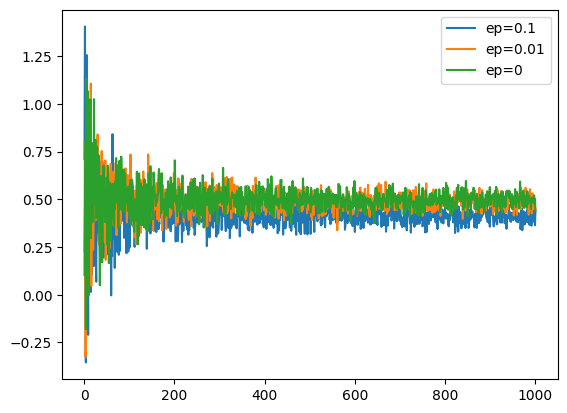

In [14]:
import matplotlib.pyplot as plt

for ep in eps:
    plt.plot(steps, results[ep], label=f'ep={ep}')
plt.legend()
plt.show()

In [5]:
from tqdm import tqdm

init_q = .25
alpha = 0.1
eps = [.1, .01, 0]
results = {}

# init q values
arm_values = np.zeros(n_arms)
n_pulled = np.zeros(n_arms)
for i in range(n_arms):
    arm_values[i] = arms[i](init_q)

steps = np.arange(1, 1001, 1)

for ep in tqdm(eps, total=len(eps)):
    average_rewards = []
    for step in tqdm(steps, total=len(steps)):
        rewards = []
        for _ in range(step):
            # select arm
            # non-greedy case
            if np.random.uniform(0,1) < ep:
                arm = np.random.randint(0, len(arms))
            # greedy case
            else:
                arm = np.argmax(arm_values)
            
            # update arm value
            n_pulled[arm] += 1
            q = arm_values[arm]

            # non-stationary
            r = np.random.normal(q, 1) # from a normal distribution with mean q_star(A_t) and variance 1, page 29
            rewards.append(r)
            q = q + alpha*(r - q)  # not sure if this is right
            # q = (((1-alpha)**len(rewards))*init_q) + sum([(alpha*(1-alpha)**(len(rewards)-i))*reward for i, reward in enumerate(rewards)]) # 2.6 page 32
            arm_values[arm] = q
        average_reward = np.mean(np.array(rewards))
        average_rewards.append(average_reward)
    results[ep] = average_rewards

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:11<00:00,  3.78s/it]


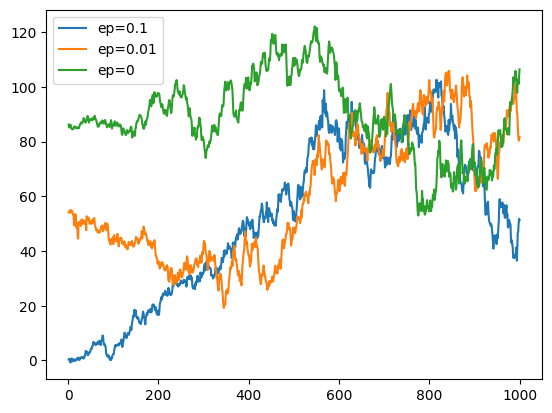

In [6]:
import matplotlib.pyplot as plt

for ep in eps:
    plt.plot(steps, results[ep], label=f'ep={ep}')
plt.legend()
plt.show()

In [33]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class MAB:
    def __init__(self, k=10, init_q=.25, max_steps=10_000):
        self.k = k
        self.init_q = init_q
        self.max_steps = max_steps

        self.arm_values = np.zeros(self.k)
        for i in range(self.k):
            self.arm_values[i] = self.initialize()

        self.n_pulled = np.zeros(self.k)

    def initialize(self):
        return self.init_q # + np.random.normal(0, 0.01) # not sure if we should apply this here

    def pull_arms(self, eps, alpha, stationary_update=True):
        average_rewards = []
        for step in tqdm(range(1, self.max_steps+1)):
            rewards = []
            for _ in range(step):
                # select arm
                # non-greedy case
                if np.random.uniform(0,1) < eps:
                    arm = np.random.randint(0, self.k)
                # greedy case
                else:
                    arm = np.argmax(self.arm_values)
                
                # update arm value
                self.n_pulled[arm] += 1
                q = self.arm_values[arm]
                r = np.random.normal(q, 1) # from a normal distribution with mean q_star(A_t) and variance 1, page 29
                rewards.append(r)

                if stationary_update:
                    n = self.n_pulled[arm]
                    q = self.stationary_update(r, q, n)

                else:
                    q = self.non_stationary_update(r, q, alpha)
                q += np.random.normal(0, 0.01) # non stationary-ness
                self.arm_values[arm] = q
            average_reward = np.mean(np.array(rewards))
            average_rewards.append(average_reward)
        return average_rewards

    def plot_rewards(self, average_rewards, label=None):
        plt.plot(range(self.max_steps), average_rewards, label=label)
        plt.xlabel("Amount of steps")
        plt.ylabel("Average reward")
        plt.title("Average reward vs. Amount of steps")
        plt.legend()
    
    def stationary_update(self, r, q, n):
        return q + ((r-q)/n)
        
    def non_stationary_update(self, r, q, alpha):
        return q + (alpha*(r - q))

In [34]:
mab_10 = MAB(10, .25, 1000)
stat_average_rewards = mab_10.pull_arms(0.1, 0.1, stationary_update=True)
non_stat_average_rewards = mab_10.pull_arms(0.1, 0.1, stationary_update=False)

100%|██████████| 1000/1000 [00:04<00:00, 215.50it/s]


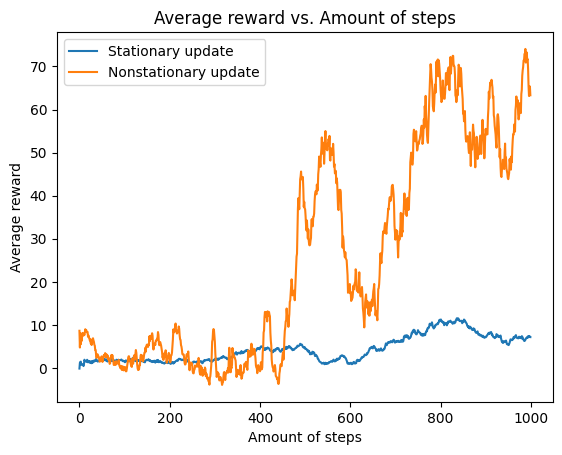

In [36]:
mab_10.plot_rewards(stat_average_rewards, label="Stationary update")
mab_10.plot_rewards(non_stat_average_rewards, label="Nonstationary update")